In [1]:
import pandas as pd
import os
import numpy as np
import pickle
from tqdm import tqdm
import wfdb
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve, roc_curve, auc
from models.wavelet import WaveletModel
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from models.transforms import Identity, MovingAvg, Downsample
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import neurokit2 as nk


In [2]:
# for preprocessing
def load_data_ptbxl(df, sampling_rate, path, standardize=False):
    if sampling_rate == 100:
        if os.path.exists(path + 'raw100.npy'):
            data = np.load(path+'raw100.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw100.npy', 'wb'), protocol=4)
    elif sampling_rate == 500:
        if os.path.exists(path + 'raw500.npy'):
            data = np.load(path+'raw500.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw500.npy', 'wb'), protocol=4)
    if standardize:
        ss = StandardScaler()
        ss.fit(np.vstack(data).flatten()[:,np.newaxis].astype(float))
        return apply_standardizer(data, ss)
    return data
    
def apply_standardizer(X, ss):
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

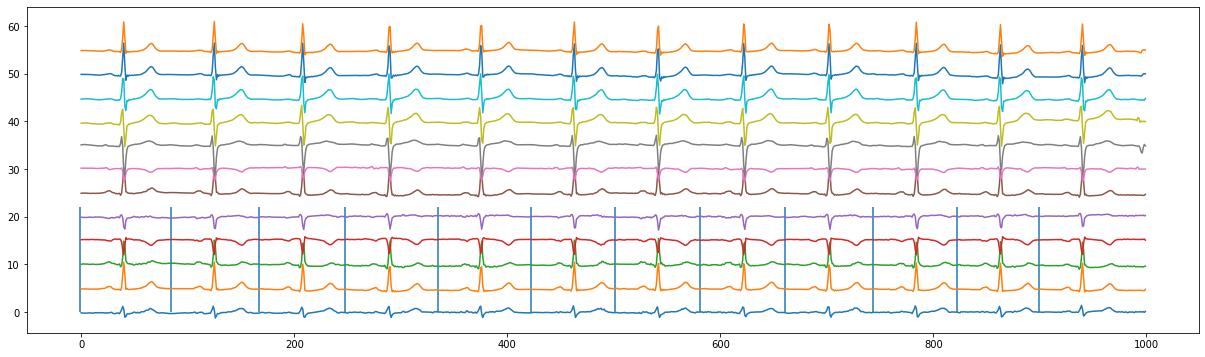

In [5]:
fig = plt.figure(figsize=(21,6))
max_length=0
for i,lead in enumerate(X[28].T):
    plt.plot(lead+i*5)
    if i==0:
        df, info = nk.ecg_process(lead, sampling_rate=100)
        peaks = np.array(info['ECG_R_Peaks'])
        max_length_ = max(peaks[1:]-peaks[:-1])
        if max_length_ > max_length:
            max_length=max_length_
        split_x = peaks-40
        plt.vlines(x=split_x,ymin=0,ymax=22)

In [3]:

def code_to_MI(code):
    scp = pd.read_csv("data/scp_statements.csv").rename({'Unnamed: 0':'scp_code'},axis=1)
    MI_codes = scp[scp.diagnostic_class=='MI']['scp_code']
    code_dict = ast.literal_eval(code)
    if 'NORM' in code_dict.keys() and code_dict['NORM'] == 100:
        return 0
    for key in code_dict:
        if key in list(MI_codes) and code_dict[key]>=80:
            return 1

In [15]:

df.loc[random.sample(sorted(df[(df['BMI']>0)&(df['BMI']<25)&(~df['MI'].isna())].index),100),'bmi_group'] = 1 
df.loc[random.sample(sorted(df[(df['BMI']<=25)&(df['BMI']<30)&(~df['MI'].isna())].index),100),'bmi_group'] = 2 
df.loc[random.sample(sorted(df[(df['BMI']<=30)&(df['BMI']<100)&(~df['MI'].isna())].index),100),'bmi_group'] = 3 
target_indices = df[~df['MI'].isna()].index
test_indices = df[~df['bmi_group'].isna()].index
train_indices = df[(~df.index.isin(test_indices))&(df.index.isin(target_indices))].index

In [5]:
import torch
import ast
import random

df = pd.read_csv('data/ptbxl_database.csv')#.reset_index(drop=True)
df['BMI'] = df['weight']/(df['height']/100)/(df['height']/100)
df['MI'] = df['scp_codes'].apply(lambda x: code_to_MI(x))
class ECG_Loader(torch.utils.data.Dataset):
    def __init__(self, df,train=True,groups=[1,2,3], shape='2d'):
        """
        Dataloader for MI prediction
        """
        # df = pd.read_csv('data/mi_df.csv')#.reset_index(drop=True)
        X = load_data_ptbxl(df,100,'data/')
        ss = StandardScaler()
        ss.fit(np.vstack(X).flatten()[:,np.newaxis].astype(float))
        X = apply_standardizer(X, ss)
        # reshape from (n_samples, seq_len) to (n_samples, 1, seq_len)
        # X = X.reshape(X.shape[0],1,X.shape[1]*X.shape[2])
        df.loc[random.sample(sorted(df[(df['BMI']>0)&(df['BMI']<25)&(~df['MI'].isna())].index),100),'bmi_group'] = 1 
        df.loc[random.sample(sorted(df[(df['BMI']<=25)&(df['BMI']<30)&(~df['MI'].isna())].index),100),'bmi_group'] = 2 
        df.loc[random.sample(sorted(df[(df['BMI']<=30)&(df['BMI']<100)&(~df['MI'].isna())].index),100),'bmi_group'] = 3 
        target_indices = df[~df['MI'].isna()].index
        test_indices = df[~df['bmi_group'].isna()].index
        if train:
            indicies = df[(~df.index.isin(test_indices))&(df.index.isin(target_indices))].index
        else:
            indicies = df[df['bmi_group'].isin(groups)].index
        y = np.array(df.iloc[indicies]['MI']) # iloc
        X = X[indicies.to_list()]
        self.X = torch.tensor(X).float()
        # one-hot encode labels
        self.Y = torch.tensor(np.array(y).reshape(len(y),1))

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :, :].T.float(), self.Y[idx,:].float()
        
train_data = ECG_Loader(df)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,drop_last=True)    
test_data = ECG_Loader(df,train=False,groups=[1,2,3])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,drop_last=True)    

(12, 1000)


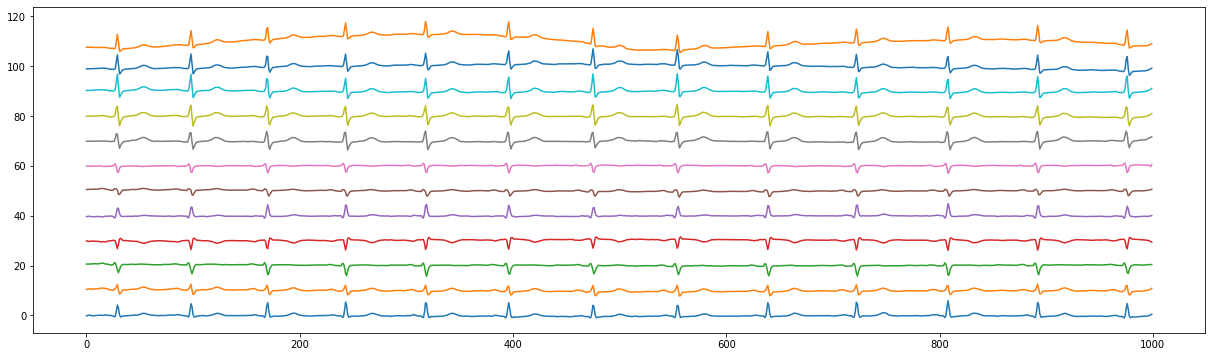

In [6]:
fig = plt.figure(figsize=(21,6))
for X,y in train_loader:
    X= X[13].numpy()
    print(X.shape)
    for i,lead in enumerate(X):
        plt.plot(lead+i*10)
    break

In [21]:
# from resnet_1d import ResNet1D
import torchmetrics
from models.transforms import Identity, MovingAvg, Downsample
from net_1d import Net1D
base_filters = 64
filter_list=[64,160,160,400,400,1024,1024]
m_blocks_list=[2,2,2,3,3,4,4]  

# model = Net1D(
#     in_channels=12, 
#     base_filters=base_filters, 
#     ratio=1.0, 
#     filter_list=filter_list, 
#     m_blocks_list=m_blocks_list, 
#     kernel_size=16, 
#     stride=2, 
#     groups_width=16,
#     verbose=False, 
#     n_classes=1)

model = torchvision.models.resnet18(num_classes=1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=2,bias=False)
EPOCHS = 3

results = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

# model = ResNet1D(in_channels=12,base_filters=64,kernel_size=32,stride=2,groups=1,n_block=4,n_classes=1)
optim = torch.optim.Adam(model.parameters())
loss = nn.MSELoss()
for epoch in range(EPOCHS):
    # training
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for x, y in train_loader:
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        yhat = model.forward(x)
        yhat = yhat.float()
        y = y.float()
        out = loss(yhat, y)
        optim.zero_grad()
        out.backward()
        optim.step()

        epoch_losses.append(out.item())
        fpr, tpr, _ = roc_curve( y.detach(),yhat.detach())
        roc_auc = auc(fpr, tpr)
        epoch_accuracies.append(roc_auc)

    epoch_loss = np.mean(epoch_losses)
    epoch_acc = np.mean(epoch_accuracies)

    # validation
    model.eval()
    epoch_val_losses = []
    epoch_val_accuracies = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            yhat = model.forward(x)
            yhat = yhat.float()
            y = y.float()
            out = loss(yhat, y)
            epoch_val_losses.append(out.item())

            fpr, tpr, _ = roc_curve(y.detach(),yhat.detach())
            roc_auc = auc(fpr, tpr)
            epoch_val_accuracies.append(roc_auc)

    epoch_val_loss = np.mean(epoch_val_losses)
    epoch_val_acc = np.mean(epoch_val_accuracies)

    # populate results
    results['loss'].append( epoch_loss )
    results['val_loss'].append( epoch_val_loss )
    results['acc'].append( epoch_acc )
    results['val_acc'].append( epoch_val_acc )

    #if (epoch+1) % 5 == 0 or epoch+1 == EPOCHS:
    print("Epoch {}/{}\tTrain Loss: {:.4f}\tTest Loss: {:.4f}\tTrain Accuracy: {:.2f}%\tTest Accuracy: {:.2f}%".format(
            epoch+1, EPOCHS, epoch_loss, epoch_val_loss, epoch_acc*100, epoch_val_acc*100) )

Epoch 1/3	Train Loss: 0.1197	Test Loss: 0.1452	Train Accuracy: 95.16%	Test Accuracy: 96.26%
Epoch 2/3	Train Loss: 0.0505	Test Loss: 0.0617	Train Accuracy: 98.36%	Test Accuracy: 97.70%
Epoch 3/3	Train Loss: 0.0456	Test Loss: 0.0353	Train Accuracy: 98.51%	Test Accuracy: 99.47%


1. Models in benchmark out-of-date
2. Tried Resnet with 2d input (1000*12), not working well
3. Trying Resnet1d with 12 channel 1d input, training loss going down.

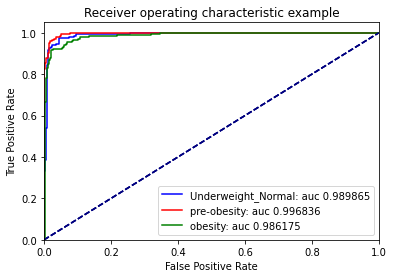

In [25]:
# ResNet 2D
results={}

plt.figure()
ys ={}
preds = {}
c_dict = {
    1: 'b',
    2: 'r',
    3: 'g'
}

gname_dict = {
    1: 'Underweight_Normal',
    2: 'pre-obesity',
    3: 'obesity'
}
for g in [1,2,3]:
    test_data = ECG_Loader(df,train=False,groups=[g])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,drop_last=True)    
    # for group in [1,2,3]: 
    ys[g] = []
    preds[g] = []
    for x, y in test_loader:
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        yhat = model.forward(x)
        yhat = yhat.detach().numpy()
        y = y.detach().numpy()
        ys[g] = np.append(ys[g],y)
        preds[g] = np.append(preds[g],yhat)
    fpr, tpr, _ = roc_curve( ys[g],preds[g])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=c_dict[g],
        label=f"{gname_dict[g]}: auc %2f" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()
# https://assets.researchsquare.com/files/rs-1550001/v1_covered.pdf?c=1650647458

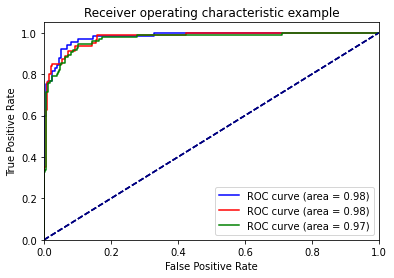

In [8]:
# results from Resnet 1d
results={}

plt.figure()
ys ={}
preds = {}
c_dict = {
    1: 'b',
    2: 'r',
    3: 'g'
}

gname_dict = {
    1: 'Underweight_Normal',
    2: 'pre-obesity',
    3: 'obesity'
}
for g in [1,2,3]:
    test_data = ECG_Loader(df,train=False,groups=[g])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,drop_last=True)    
    # for group in [1,2,3]: 
    ys[g] = []
    preds[g] = []
    for x, y in test_loader:
        yhat = model.forward(x)
        yhat = yhat.detach().numpy()
        y = y.detach().numpy()
        ys[g] = np.append(ys[g],y)
        preds[g] = np.append(preds[g],yhat)
    fpr, tpr, _ = roc_curve( ys[g],preds[g])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=c_dict[g],
        label="auc" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

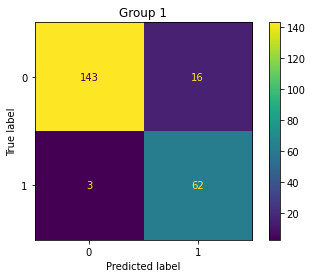

<Figure size 432x288 with 0 Axes>

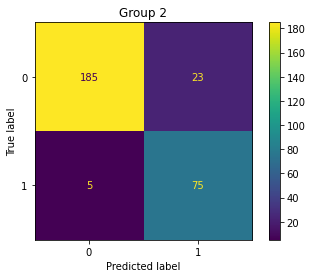

<Figure size 432x288 with 0 Axes>

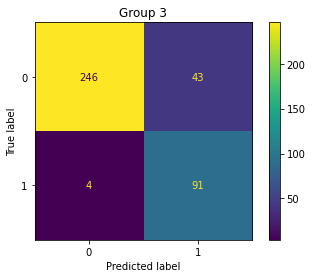

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for g in [1,2,3]:
    plt.figure()
    y = ys[g]
    pred = preds[g]
    pred = [0 if p<pred.mean() else 1 for p in pred]
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Group {g}")

In [ ]:
# https://neurokit2.readthedocs.io/en/latest/examples/heartbeats.html
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = df["ECG_Clean"]
plot = nk.events_plot(rpeaks, cleaned_ecg)